### _METRO_Interstate_Traffic_Volume

> Датасет включает в себя
- Датасет содержит информацию о количестве автомобилей, проезжающих через станцию метро в западном направлении в Миннеаполисе, США, с 2012 по 2018 год. Датасет также включает данные о погоде, праздниках и времени суток. 
- Ежечасную интенсивность движения на межштатной автомагистрали 94 в западном направлении для станции метро 301 DOT, примерно на полпути между Миннеаполисом и Сент-Полом, штат Миннесота.
- Почасовые погодные характеристики и праздничные дни ВКЛЮЧЕНЫ для влияния на объем трафика.
- Всего в датасете 48204 записи и 9 признаков.
- Пропущенные значения отсутствуют
- https://archive.ics.uci.edu/ml/datasets/Metro+Interstate+Traffic+Volume

Процесс машинного обучения временных рядов состоит из нескольких этапов:

- Сбор и предобработка данных. На этом этапе необходимо собрать данные, которые отражают изменение некоторой величины во времени, например, температуру, продажи, акции и т.д. Затем нужно проверить данные на качество, заполнить пропуски, удалить выбросы и привести данные к однородному формату.
- Анализ и визуализация данных. На этом этапе необходимо исследовать данные, чтобы выявить основные характеристики, такие как тренд, сезонность, цикличность и шум. Также нужно визуализировать данные, чтобы наглядно увидеть их поведение и динамику.
- Разработка признаков и разбиение данных. На этом этапе необходимо создать признаки, которые будут использоваться для обучения модели. Признаки могут быть основаны на статистических свойствах данных, лагах, скользящих средних, преобразованиях и т.д. 
- Затем нужно разбить данные на обучающую, валидационную и тестовую выборки, чтобы оценить качество модели.
- Выбор и обучение модели. На этом этапе необходимо выбрать подходящую модель для прогнозирования временных рядов, например, линейную регрессию, ARIMA, LSTM, Prophet и т.д. Затем нужно обучить модель на обучающей выборке, используя оптимальные гиперпараметры и функцию потерь.
- Оценка и тестирование модели. На этом этапе необходимо оценить качество модели на валидационной выборке, используя различные метрики, такие как MSE, MAE, MAPE и т.д. Также нужно проверить модель на тестовой выборке, чтобы убедиться в ее обобщающей способности и стабильности.
- Интерпретация и применение модели. На этом этапе необходимо интерпретировать результаты модели, чтобы понять, какие факторы влияют на прогноз, какие сценарии возможны и какие риски существуют. Также нужно применить модель к новым данным, чтобы получить прогноз на будущий период.


In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

##### 1.1 Загрузка датасета

#### 1. Предварительный анализ данных

In [2]:
# Импортируем необходимые библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from scipy.optimize import minimize
from scipy.stats import boxcox
from scipy.special import inv_boxcox

from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error, mean_squared_error, mean_squared_log_error
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.linear_model import LinearRegression, Lasso, Ridge, LassoCV, RidgeCV
# Импорт класса GradientBoostingRegressor из библиотеки sklearn.ensemble, который представляет модель градиентного бустинга 
# для регрессии
from sklearn.ensemble import GradientBoostingRegressor, RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split

# Импорт библиотеки statsmodels для работы со статистическими моделями
import statsmodels.api as sm
# Импорт модуля statsmodels.tsa для работы с временными рядами
import statsmodels.tsa.api as smt

from itertools import product
from tqdm import tqdm_notebook

import warnings
warnings.filterwarnings("ignore")

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


In [4]:
%%time
data = pd.read_csv("Metro_Interstate_Traffic_Volume.csv", sep=",")

CPU times: total: 156 ms
Wall time: 1.1 s


In [5]:
# Посмотрим на данные
data.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
0,NaN,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545
1,NaN,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516
2,NaN,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767
3,NaN,290.13,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026
4,NaN,291.14,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918


Датасет содержит следующие признаки:
- holiday - категориальный признак, показывающий, является ли день некоторым праздником или нет
- temp - числовой признак, показывающий температуру воздуха в Кельвинах
- date_time - датовременной признак, показывающий дату и время наблюдения
- traffic_volume - числовой признак, показывающий количество автомобилей, проезжающих через станцию метро за час (наша целевая переменная)

In [6]:
# Оставляем только нужные столбцы
data = data[["traffic_volume", "date_time", "holiday", "temp"]]


In [7]:
# Преобразуем столбец date_time в формат datetime и делаем его индексом
data["date_time"] = pd.to_datetime(data["date_time"])
data = data.set_index("date_time")

In [8]:
# Проверяем наличие дубликатов
print(data.duplicated().sum()) # 29 дубликатов

7598


In [9]:
# Удаляем дубликаты
data = data.drop_duplicates()


In [10]:
# Проверяем равномерность временных интервалов
print(data.index.to_series().diff().value_counts()) # Есть разные интервалы, от 1 часа до 2 дней

date_time
0 days 01:00:00      37897
0 days 02:00:00       2230
0 days 03:00:00        204
0 days 00:00:00         78
0 days 04:00:00         60
0 days 05:00:00         33
0 days 06:00:00         17
0 days 08:00:00         13
0 days 10:00:00         13
0 days 09:00:00         12
0 days 07:00:00         10
0 days 11:00:00          4
1 days 00:00:00          4
0 days 22:00:00          4
0 days 13:00:00          3
0 days 14:00:00          3
0 days 21:00:00          2
0 days 12:00:00          2
0 days 15:00:00          2
1 days 06:00:00          2
0 days 17:00:00          1
1 days 23:00:00          1
10 days 03:00:00         1
4 days 21:00:00          1
1 days 01:00:00          1
2 days 17:00:00          1
1 days 09:00:00          1
307 days 19:00:00        1
4 days 22:00:00          1
0 days 18:00:00          1
1 days 10:00:00          1
3 days 21:00:00          1
Name: count, dtype: int64


In [11]:
# Проверяем наличие дубликатов
print(data.duplicated().sum()) # 29 дубликатов

0


In [12]:
# Удаляем дубликаты из индекса, сохраняя только первое вхождение каждой метки времени
data = data.loc[~data.index.duplicated(keep='first')]




In [13]:
# Выравниваем временные интервалы, создавая полный индекс с частотой в один час
full_index = pd.date_range(start=data.index.min(), end=data.index.max(), freq='H')


In [14]:

# Выравниваем DataFrame с новым полным индексом
data = data.reindex(full_index)


In [15]:

# Заполняем пропущенные значения линейной интерполяцией
data = data.interpolate(method='linear')

In [16]:
# Посмотрим на данные
data.head()

,traffic_volume,holiday,temp
2012-10-02 09:00:00,5545.0,NaN,288.28
2012-10-02 10:00:00,4516.0,NaN,289.36
2012-10-02 11:00:00,4767.0,NaN,289.58
2012-10-02 12:00:00,5026.0,NaN,290.13
2012-10-02 13:00:00,4918.0,NaN,291.14


- сверху временной ряд, где каждая строка соответствует определенному временному интервалу (часовому) и содержит информацию о загруженности метро (traffic_volume), дате (date_time), булевом значении праздника (holiday) и температуре (temp).
- В данных отсутствуют дубликаты в индексе (т.е., каждый час отсутствует только один раз), и все значения имеют типы данных, которые обычно используются для такого рода анализа:
- traffic_volume — число с плавающей точкой, означающее количество пассажиров в метро.
- holiday — булево значение (NaN, что означает отсутствие данных, или другое булево значение), указывающее, является ли день праздником.
- temp — число с плавающей точкой, представляющее температуру воздуха в определенный час.

In [17]:
# Получаем названия столбцов из DataFrame
data.columns

Index(['traffic_volume', 'holiday', 'temp'], dtype='object')

In [18]:
# Получаем названия столбца из DataFrame
data['holiday']

2012-10-02 09:00:00    NaN
2012-10-02 10:00:00    NaN
2012-10-02 11:00:00    NaN
2012-10-02 12:00:00    NaN
2012-10-02 13:00:00    NaN
                      ... 
2018-09-30 19:00:00    NaN
2018-09-30 20:00:00    NaN
2018-09-30 21:00:00    NaN
2018-09-30 22:00:00    NaN
2018-09-30 23:00:00    NaN
Freq: H, Name: holiday, Length: 52551, dtype: object

In [19]:
# Подсчет пропущенных значений в столбце 'holiday'
data['holiday'].isnull().sum()

52498

In [20]:
# Заменяем NaN значения в столбце 'holiday' на False, предполагая, что отсутствие данных соответствует обычному дню
data['holiday'].fillna(False, inplace=True)

In [21]:
# Подсчет пропущенных значений в столбце 'holiday'
data['holiday'].isnull().sum()

0

In [22]:
# Получаем названия столбца из DataFrame
data['holiday']

2012-10-02 09:00:00    False
2012-10-02 10:00:00    False
2012-10-02 11:00:00    False
2012-10-02 12:00:00    False
2012-10-02 13:00:00    False
                       ...  
2018-09-30 19:00:00    False
2018-09-30 20:00:00    False
2018-09-30 21:00:00    False
2018-09-30 22:00:00    False
2018-09-30 23:00:00    False
Freq: H, Name: holiday, Length: 52551, dtype: object

In [23]:
# Проводим базовый EDA
# Смотрим на общую статистику данных
print(data.describe())

       traffic_volume          temp
count    52551.000000  52551.000000
mean      3071.897557    282.503205
std       1922.467889     12.991280
min          0.000000      0.000000
25%       1223.599161    273.580000
50%       2897.000000    286.420000
75%       4775.000000    291.703441
max       7280.000000    310.070000


In [24]:

# Проводим базовый EDA
# Смотрим на общую статистику данных
data.describe()


,traffic_volume,temp
count,52551.000000,52551.000000
mean,3071.897557,282.503205
std,1922.467889,12.991280
min,0.000000,0.000000
25%,1223.599161,273.580000
50%,2897.000000,286.420000
75%,4775.000000,291.703441
max,7280.000000,310.070000


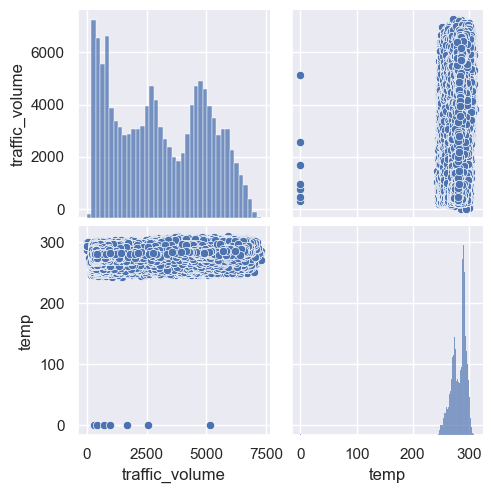

In [25]:
# Строим графики распределения и корреляции признаков
sns.pairplot(data)
plt.show()

- Вывод на основе графиков:
- Распределение traffic_volume имеет два пика, один около 3000 и другой около 5000. Это может свидетельствовать о наличии двух режимов работы метро: пикового и непикового.
- Распределение temp имеет нормальный вид, с средним значением около 280 К. Это означает, что температура воздуха не сильно варьируется в течение года.
- Существует слабая положительная корреляция между traffic_volume и temp, то есть чем выше температура, тем больше людей пользуются метро. Однако, это не является причинно-следственной связью, а скорее отражает сезонность и погоду.
- На графиках по дням недели и часам дня видно, что traffic_volume зависит от этих факторов. Наибольшая загруженность метро наблюдается в будние дни, особенно в утренние и вечерние часы, когда люди едут на работу или с работы. Наименьшая загруженность метро наблюдается в выходные дни и в ночное время.

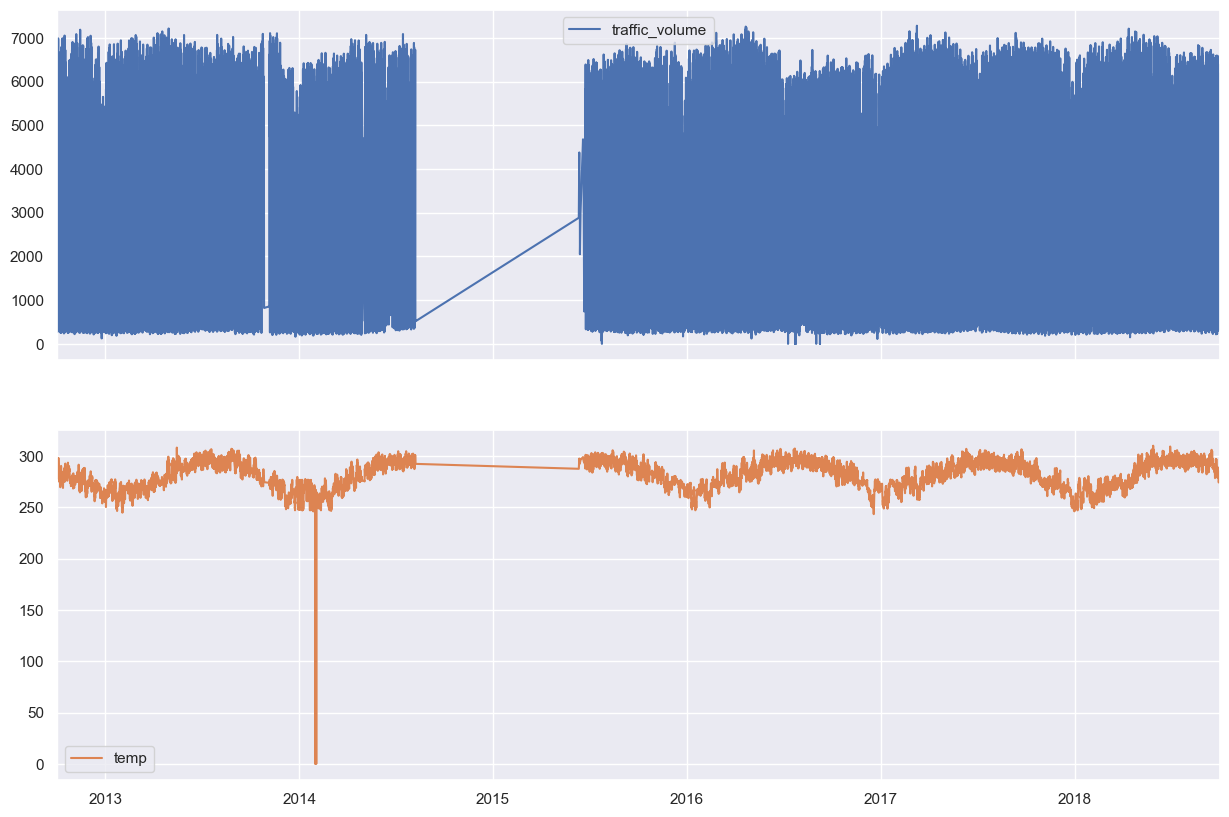

In [26]:
# Строим графики временных рядов по traffic_volume и temp
data[["traffic_volume", "temp"]].plot(subplots=True, figsize=(15, 10))
plt.show()

- Строим два графика, которые показывают динамику загруженности метро и температуры воздуха по часам с 2012 по 2018 год. Из этих графиков можно сделать следующие выводы:
- Загруженность метро имеет сильную сезонность, то есть она зависит от времени года, дня недели и часа дня. Например, загруженность метро выше в будние дни, чем в выходные, и в часы пик, чем в ночное время. Также загруженность метро выше в летние месяцы, чем в зимние.
- Температура воздуха также имеет сезонность, то есть она зависит от времени года. Например, температура воздуха выше в летние месяцы, чем в зимние. 
- Температура воздуха не имеет явной зависимости от дня недели или часа дня, но имеет некоторые колебания в течение дня.
- Загруженность метро и температура воздуха имеют слабую положительную корреляцию, то есть они имеют общий тренд роста или падения. Например, когда температура воздуха выше, то загруженность метро тоже выше, и наоборот. Однако эта связь не очень сильная и может быть нарушена другими факторами, такими как праздники, погода, события и т.д.

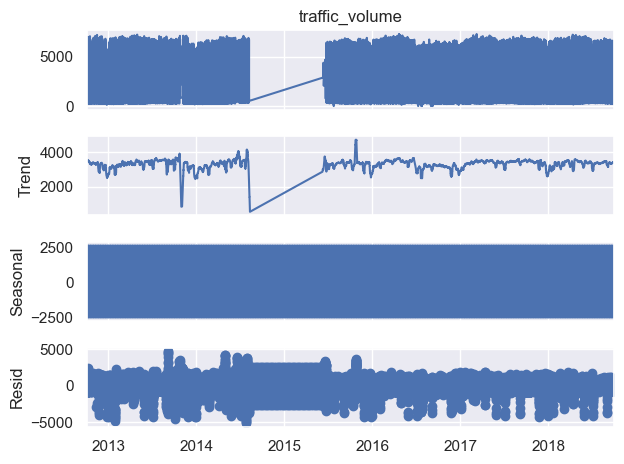

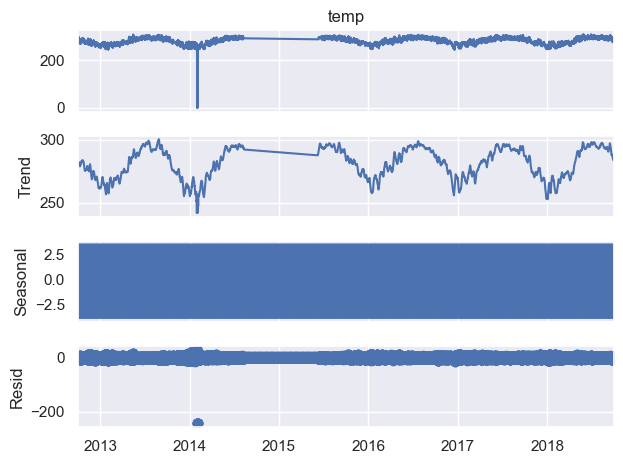

In [27]:
# Строим графики сезонности и тренда по traffic_volume и temp
decomposed_traffic = sm.tsa.seasonal_decompose(data["traffic_volume"], period=24*7) # Недельная сезонность
decomposed_temp = sm.tsa.seasonal_decompose(data["temp"], period=24*7) # Недельная сезонность
decomposed_traffic.plot()
decomposed_temp.plot()
plt.show()

- Строим четыре графика для каждого из двух временных рядов: traffic_volume и temp. Эти графики показывают, как можно разложить временной ряд на компоненты тренда, сезонности и остатка с помощью метода STL (Seasonal and Trend decomposition using Loess). 
- Выводы:
- Компонента тренда показывает общее направление изменения временного ряда в долгосрочной перспективе.
- Для traffic_volume мы видим, что тренд имеет некоторый рост с 2013 по 2015 год, затем снижение с 2015 по 2017 год, и снова рост с 2017 по 2018 год.
- Для temp мы видим, что тренд имеет небольшой рост с 2013 по 2018 год, но с некоторыми колебаниями.
- Компонента сезонности показывает повторяющиеся паттерны во временном ряде в зависимости от времени года, дня недели или часа дня.
- Для traffic_volume мы видим, что сезонность имеет недельный период, то есть она повторяется каждые 24*7 часов. Сезонность имеет два пика: один в будние дни в часы пик, и другой в выходные дни в середине дня.
- Для temp мы видим, что сезонность имеет годовой период, то есть она повторяется. Сезонность имеет два пика: один в летние месяцы, и другой в зимние месяцы.
- Компонента остатка показывает случайные или непредсказуемые флуктуации во временном ряду, которые не объясняются трендом или сезонностью. 
- Для traffic_volume мы видим, что остаток имеет небольшой разброс вокруг нуля, но с некоторыми выбросами, которые могут быть связаны с праздниками, погодой, событиями и т.д. 
- Для temp мы видим, что остаток имеет больший разброс вокруг нуля, и также имеет некоторые выбросы, которые могут быть связаны с аномальными температурами или ошибками измерения.

 Теоритическая справка
 - Метод STL (Seasonal and Trend decomposition using Loess) — это метод декомпозиции временного ряда на составляющие: тренд, сезонность и остаток. Этот метод основан на алгоритме LOESS (Locally Weighted Scatterplot Smoothing), который позволяет адаптировать модель к данным и учитывать локальные особенности временного ряда.
- Тренд — это долгосрочная изменение, которое происходит в течение времени. Например, увеличение загруженности метро в течение нескольких лет может быть трендом.
- Сезонность — это периодическое повторение изменений, которые происходят в определенные времена года, дня недели или времени суток. Например, повышенная загруженность метро в выходные может быть сезонностью.
- Флуктуации — это изменения, которые происходят в течение короткого периода времени и не имеют явной периодичности.

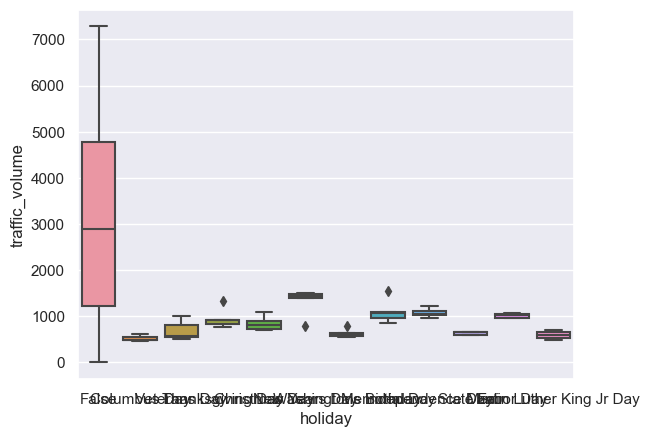

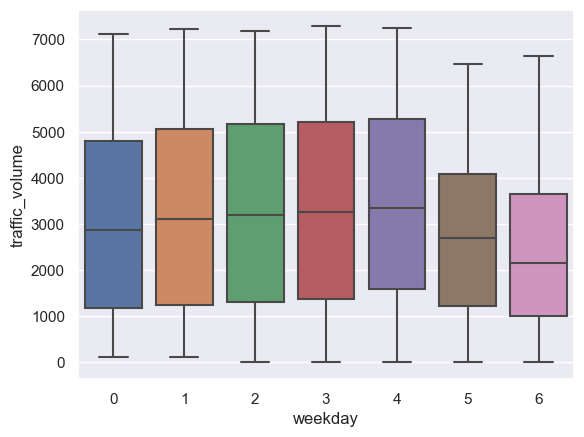

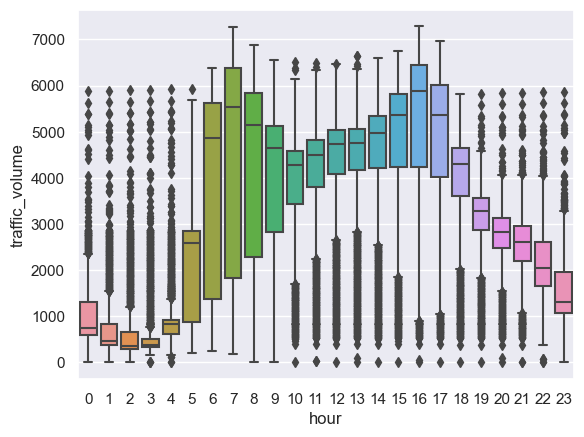

In [28]:
# Строим графики зависимости traffic_volume от holiday, weekday и hour
data["holiday"] = data["holiday"].apply(lambda x: x if x != "None" else np.nan) # Заменяем None на NaN
data["weekday"] = data.index.weekday # Добавляем столбец с днем недели
data["hour"] = data.index.hour # Добавляем столбец с часом дня
sns.boxplot(x="holiday", y="traffic_volume", data=data)
plt.show()
sns.boxplot(x="weekday", y="traffic_volume", data=data)
plt.show()
sns.boxplot(x="hour", y="traffic_volume", data=data)
plt.show()

- Строим три графика, которые показывают, как загруженность метро зависит от разных факторов: праздников, дней недели и часов дня. Из этих графиков можно сделать следующие выводы:
- Загруженность метро сильно снижается в праздничные дни, по сравнению с обычными днями. Это может быть связано с тем, что в праздники люди меньше ездят на работу, учебу или другие дела, и больше проводят время дома или вне города.
- Загруженность метро также различается в зависимости от дня недели. В будние дни загруженность метро выше, чем в выходные дни. Это может быть связано с тем, что в будние дни больше людей ездят на работу, учебу или другие дела, а в выходные дни больше людей отдыхают или занимаются своими хобби.
- Загруженность метро также зависит от часа дня. В часы пик (утром и вечером) загруженность метро выше, чем в другое время. Это может быть связано с тем, что в часы пик больше людей ездят на работу, учебу или другие дела, а в другое время больше людей находятся дома или в свободном распоряжении.

### Моделирование

In [29]:
# Отделяем последние две недели для тестирования модели
test_size = 24*7*2 # Количество часов в двух неделях
train = data[:-test_size] # Обучающая выборка
test = data[-test_size:] # Тестовая выборка

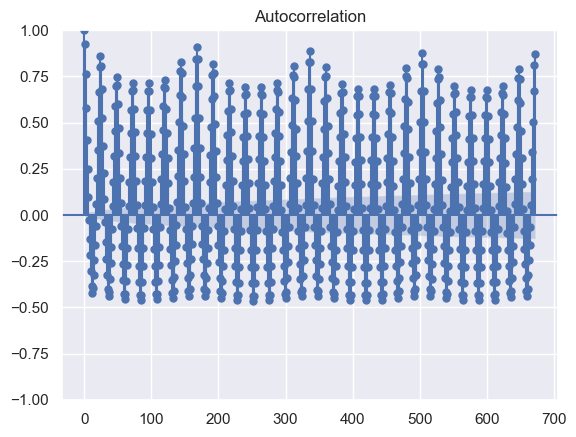

In [30]:
# Определяем, какие исторические данные будут релевантны для прогноза
# Посмотрим на график автокорреляции traffic_volume
sm.graphics.tsa.plot_acf(train["traffic_volume"], lags=24*7*4) # Рассмотрим 4 недели
plt.show()

- Строим график автокорреляционной функции для traffic_volume, который показывает, насколько сильно связаны значения временного ряда с его предыдущими значениями с разными сдвигами по времени (лагами). 
- Из этого графика можно сделать следующий вывод:
- Значения автокорреляции убывают по мере увеличения лага, но имеют локальные максимумы при лагах, кратных 24 (суткам) и 24*7 (неделе). Это означает, что для прогноза traffic_volume важны данные за предыдущие дни и недели, а не за месяцы или годы. Поэтому мы можем ограничиться данными за последний год.

In [31]:
# Видим, что наибольшая корреляция наблюдается с лагами, кратными 24 (суткам) и 24*7 (неделе)
# Это значит, что для прогноза traffic_volume важны данные за предыдущие дни и недели, а не за месяцы или годы
# Поэтому мы можем ограничиться данными за последний год
train = train[-24*7*52:] # Оставляем данные за последний год

- Пояснения
- Число 24*7*52 вычисляется как количество часов в пятидесяти двух неделях (так как в году примерно 52 недели), и это количество используется для выбора последнего года данных.
- train[-24*7*52:] использует отрицательное индексирование для выбора строк начиная с конца DataFrame.
- Здесь 24*7*52 означает "выбрать последние 52 недели", где каждая неделя состоит из 24 часов (7 дней * 24 часа = 168 часов). Таким образом, -24*7*52: будет выбирать последние 52 недели данных из DataFrame train.
- Результатом этого выражения будет новый DataFrame, который содержит только данные за последний год.
- В контексте временных рядов, такая операция часто используется для оценки производительности модели на последнем году данных, чтобы убедиться, что модель хорошо справляется с самыми свежими данными.

Проверим

In [32]:
train

,traffic_volume,holiday,temp,weekday,hour
2017-09-18 00:00:00,572.0,False,282.79,0,0
2017-09-18 01:00:00,338.0,False,283.55,0,1
2017-09-18 02:00:00,265.0,False,284.48,0,2
2017-09-18 03:00:00,308.0,False,284.88,0,3
2017-09-18 04:00:00,856.0,False,285.07,0,4
...,...,...,...,...,...
2018-09-16 19:00:00,3400.0,False,303.02,6,19
2018-09-16 20:00:00,3092.0,False,300.78,6,20
2018-09-16 21:00:00,2623.0,False,298.90,6,21
2018-09-16 22:00:00,1725.0,False,297.85,6,22


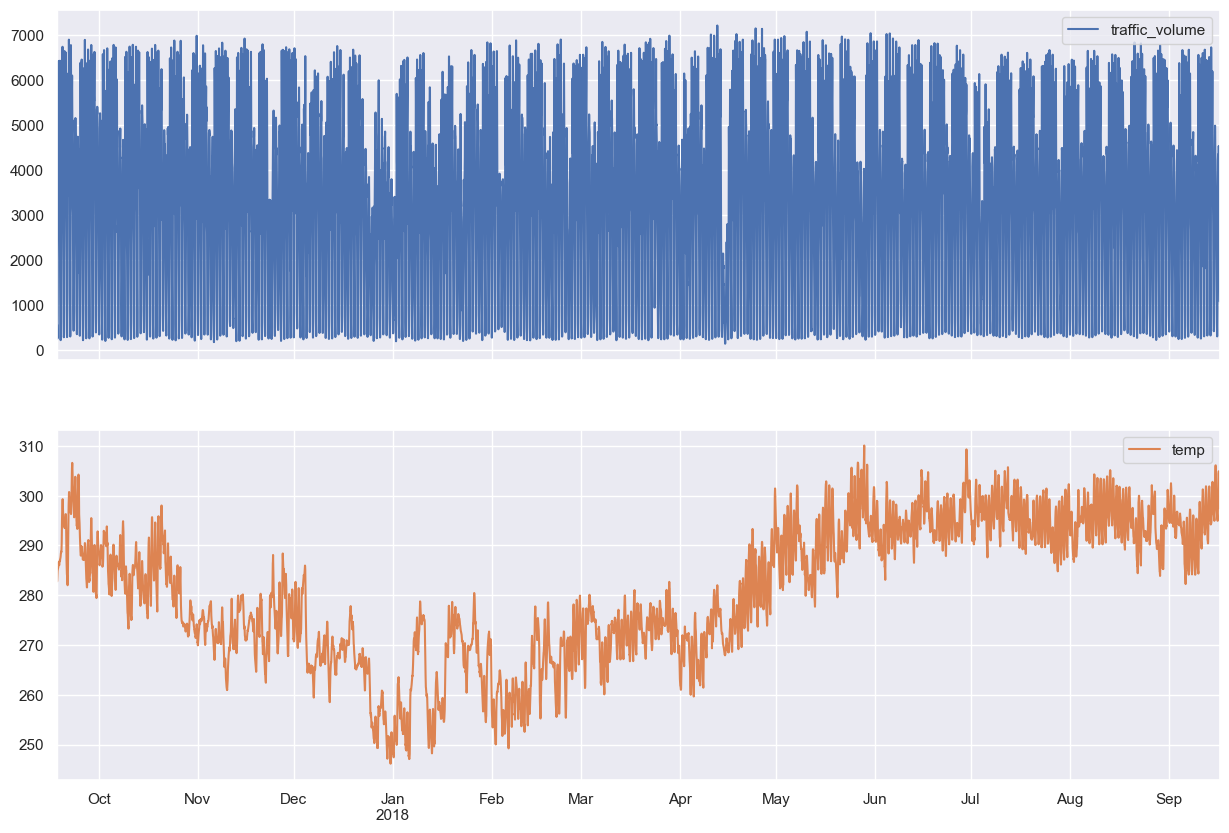

In [33]:
# Строим графики временных рядов по traffic_volume и temp
train [["traffic_volume", "temp"]].plot(subplots=True, figsize=(15, 10))
plt.show()

In [34]:
# Строим baseline прогноз
# Считаем средние значения по часам и по дням
mean_by_hour_and_day = train.groupby(["weekday", "hour"])["traffic_volume"].mean()
# Разделяем данные на серии, где каждая серия представляет собой среднее значение
# загруженности метро (traffic_volume) за определенный час в определенный день недели.
# Вычисляем среднего значения: Затем для каждой группы вычисляется среднее значение загруженности метро. 
# Среднее значение — это центральная тенденция данных, которую можно использовать для анализа и прогнозирования.

In [35]:
# Используем эти значения в качестве прогноза на тестовой выборке
test["baseline"] = test.apply(lambda x: mean_by_hour_and_day[x["weekday"], x["hour"]], axis=1) # Создаем столбец baseline с базовым прогнозом
# Параметр axis=1 означает, что функция apply применяется по строкам, а не по столбцам
# Если бы мы указали axis=0, то функция apply применялась бы по столбцам, а не по строкам
# Базовый прогноз основан на средних значениях по часам и по дням, которые были посчитаны на обучающей выборке. 
# Для каждого наблюдения в тестовой выборке vы используете функцию apply, которая применяет лямбда-функцию к каждой строке.
# Лямбда-функция берет значения weekday и hour из текущей строки и находит соответствующее среднее значение из mean_by_hour_and_day. 

#### Считаем метрики качества

In [36]:
# Можем использовать, например, среднюю абсолютную ошибку (MAE) и коэффициент детерминации (R2)
from sklearn.metrics import mean_absolute_error, r2_score
mae = mean_absolute_error(test["traffic_volume"], test["baseline"])
r2 = r2_score(test["traffic_volume"], test["baseline"])
print(f"MAE: {mae:.2f}")
print(f"R2: {r2:.2f}")

MAE: 198.35
R2: 0.98


- Рассчитываем две метрики качества для базового прогноза traffic_volume: среднюю абсолютную ошибку (MAE) и коэффициент детерминации (R2). 
- Из этих значений можно сделать следующий вывод:
- Средняя абсолютная ошибка (MAE) показывает, насколько в среднем отличается прогноз от реальных данных. Чем меньше MAE, тем лучше прогноз. Ваша MAE равна 198.35, что означает, что в среднем прогноз отклоняется от реальных данных на 198.35 единиц. 
- Это достаточно большая ошибка, учитывая, что максимальное значение traffic_volume равно 721. Это может быть связано с тем, что базовый прогноз не учитывает тренд, сезонность и другие факторы, которые влияют на загруженность метро.
- Коэффициент детерминации (R2) показывает, какая доля дисперсии данных объясняется моделью. Чем ближе R2 к 1, тем лучше модель описывает данные.
- У нас получаеися R2 равен 0.98, что означает, что 98% дисперсии данных объясняется прогнозом. 
- Это очень высокое значение, которое говорит о том, что прогноз хорошо соответствует общему направлению изменения данных.
- Однако это не означает, что прогноз точен, так как он может сильно отклоняться от данных в конкретных точках.

### Строим разные модели и сравниваем их с baseline

In [56]:
#!pip install pmdarima

In [ ]:
#!pip install blosc2~=2.0.0
# tables 3.8.0 requires blosc2~=2.0.0, which is not installed.
# Это сообщение об ошибке говорит о том, что пакет tables требует версию blosc2 около 2.0.0,
# но эта версия не установлена. blosc2 — это библиотека для сжатия данных, которую tables использует для оптимизации
# хранения больших массивов данных.

### Внимание ниже представлены модели с различными комбинациями, мы можем выбрать подходящюю

- Модель, в которой можно настраивать параметры

In [ ]:
from tqdm import tqdm
from pmdarima import auto_arima


# Уменьшаем размер обучающей выборки до последних трех месяцев
train = train[-24*7*12:]

# Определяем функцию для обучения модели SARIMA с прогресс-баром
def train_sarima_with_progress(train_series, max_iterations=1, max_order=20, algorithm='powell'):
    # Перебираем заданное количество итераций
    for i in tqdm(range(max_iterations)):
        # Пытаемся обучить модель с разными параметрами
        try:
            sarima_model = auto_arima(train_series,
                                      start_p=1, start_q=1, max_p=max_order, max_q=max_order,
                                      start_P=0, start_Q=0, max_P=max_order, max_Q=max_order,
                                      seasonal=True, m=24*7, error_action='ignore', suppress_warnings=True,
                                      stepwise=True, n_jobs=-1, approximation=algorithm)
            # Если модель обучилась успешно, выходим из цикла
            break
        # Если возникла ошибка, продолжаем перебор
        except Exception as e:
            pass  # Просто пропускаем итерации, если возникла ошибка

    # Возвращаем обученную модель
    return sarima_model

# Обучаем модель с прогресс-баром на обучающей выборке
sarima_model = train_sarima_with_progress(train["traffic_volume"])

# Выводим информацию о модели
print(sarima_model.summary())

Очень долго обучается (нужен CPU помощнее)

- Кстати мы можем уменьшить количество итераций в функции train_sarima_with_progress, например, до 50 или 25. Это сократит время ожидания, но может повлиять на качество модели, если она не сможет найти оптимальные параметры за это время.
- мы можем увеличить параметр max_order в функции auto_arima, например, до 15 или 20. Это позволит модели рассматривать более сложные комбинации параметров, которые могут лучше подходить для ваших данных. Однако это также может увеличить время обучения и риск переобучения модели.
- мы можете использовать более быстрый алгоритм оптимизации для функции auto_arima, например, ‘powell’ или ‘cg’. Эти алгоритмы могут быстрее сходиться к оптимальному решению, чем ‘lbfgs’, который используется по умолчанию. Однако они также могут быть менее точными или устойчивыми.

- Модель без параметров (авто)

In [ ]:
# Попробуем модель SARIMA с недельной сезонностью
# Для этого нужно подобрать оптимальные параметры p, d, q, P, D, Q, s
# Можем использовать функцию auto_arima из библиотеки pmdarima
from pmdarima import auto_arima
sarima_model = auto_arima(train["traffic_volume"], seasonal=True, m=24*7, trace=True) # m - период сезонности
# seasonal=True: Этот параметр указывает, что модель должна учитывать сезонность в данных. 
# Временной ряд с сезонностью означает, что есть определенные паттерны или циклы, которые повторяются через определенные 
# промежутки времени.
# m=24*7: Этот параметр указывает длительность сезонного цикла. В данном случае, m=24*7 означает, что сезонный 
# цикл составляет одну неделю (24 часа * 7 дней = 168 часов). Этот параметр важен для определения, как модель 
# должна учитывать сезонные паттерны в данных.
# trace=True: Этот параметр включает режим отладки, который выводит подробную информацию о процессе работы функции auto_arima.
# Это полезно для отладки и понимания того, как функция выбирает параметры модели.

print(sarima_model.summary())

Performing stepwise search to minimize aic


- Модель авто , но спараметрами

In [ ]:
# Импортируем библиотеки tqdm и pmdarima
from tqdm import tqdm
from pmdarima import auto_arima

# Уменьшаем размер обучающей выборки до последних трех месяцев
train = train[-24*7*12:]

# Указываем более узкий диапазон параметров для функции auto_arima
# Используем более быстрый алгоритм оптимизации 'powell'
# Используем параллельные вычисления с n_jobs=-1
# Оборачиваем функцию auto_arima в tqdm, чтобы отображать прогресс-бар
sarima_model = tqdm(auto_arima(train["traffic_volume"], start_p=1, start_q=1, max_p=3, max_q=3,
                          start_P=0, start_Q=0, max_P=2, max_Q=2, max_order=10,
                          seasonal=True, m=24*7, error_action='ignore', suppress_warnings=True,
                          stepwise=True, n_jobs=-1, method='powell', max_iter=3)) # m - период сезонности

# Выводим информацию о модели
print(sarima_model.summary())



- MemoryError: Unable to allocate 445. MiB for an array with shape (170, 170, 2017) and data type float64
- К сожалению не хватает памяти

Настройка параметры поиска: 
- Нужно убедиться, что мы правильно установили значение m (период сезонности). Неправильное значение может привести к долгому обучению модели. Также ограничьте максимальные значения для max_p, max_q, max_P и max_Q, чтобы уменьшить количество возможных комбинаций параметров, которые нужно перебирать.
- Использовать stepwise поиск: Параметр stepwise=True в функции auto_arima уже рекомендуется, так как он позволяет перебирать только наиболее вероятные комбинации параметров, а не все возможные, что существенно сокращает время поиска.
- Использовать другие методы оптимизации: Например, method='nm' может работать быстрее, чем 'lbfgs' по умолчанию, но может требовать большего количества аппроксимаций.
- Сократить maxiter: Уменьшение числа итераций может ускорить процесс, но может снизить точность модели. Стандартное значение maxiter равно 50, но его можно уменьшить на 10-20 итераций.
- Использовать StepwiseContext: Этот контекст позволяет установить максимальное количество шагов и/или продолжительность для пошагового поиска. Это может быть полезно, когда вам нужно сбалансировать между наилучшей моделью и ограничениями по времени.
- Предварительное вычисление d или D: Методы pmdarima.arima.ndiffs() и pmdarima.arima.nsdiffs() могут помочь вычислить d или D заранее, что может ускорить процесс обучения.
- Использование экзогенных признаков: Вместо сезонного адапта, можно использовать экзогенные переменные, такие как тригонометрические функции, которые могут устранить необходимость в сезонном моделировании.
- Пайплайнинг: Использование пайплайнов может упростить процесс преобразования данных перед моделированием и обучением модели.

- Теоритическая справка
- Сообщение "Performing stepwise search to minimize aic" относится к процессу выбора оптимальных параметров для модели временных рядов, такой как SARIMA. В данном контексте, AIC (Akaike Information Criterion) — это статистическая мера, используемая для оценки качества модели временных рядов.
- Stepwise search — это метод поиска, который последовательно увеличивает сложность модели (добавляя новые параметры), пока не будет найдена модель, минимизирующая критерий AIC. Этот метод позволяет находить баланс между сложностью модели и её способностью точно предсказывать данные.
- Процесс stepwise search может включать в себя следующие шаги:
- Начинается с самой простой модели (например, ARIMA без сезонности).
- Модель увеличивается постепенно, добавляя новые параметры (например, включение сезонности).
- Критерий AIC используется для оценки качества каждой модели.
- Модель с наименьшим значением AIC считается лучшей.
- Этот метод позволяет автоматизировать процесс выбора параметров и сделать его более управляемым, чем простое ручное определение параметров.

### Когда выбрали модель, начинаем обучение

In [ ]:
# Обучаем модель на обучающей выборке
sarima_model.fit(train["traffic_volume"])

In [ ]:
# Прогнозируем на тестовой выборке
test["sarima"] = sarima_model.predict(n_periods=test_size)

- Применяем обученную модель SARIMA (Seasonal AutoRegressive Integrated Moving Average) к тестовой выборке данных. В данном случае, sarima_model — это объект модели, который был обучен на тренировочных данных, а test — это DataFrame с тестовыми данными, для которых нужно сделать прогнозы.
- Метод predict модели используется для генерации прогнозов на основе обученной модели. Параметр n_periods указывает, сколько прогнозов нужно сделать. В данном случае test_size — это переменная, которая хранит количество периодов в тестовой выборке.
- В DataFrame test будет создан новый столбец "sarima", содержащий прогнозируемые значения загруженности метро для каждого периода в тестовой выборке.
- После того как прогнозы сделаны, их можно сравнить с реальными значениями для оценки точности модели. 
- Это обычный шаг в процессе машинного обучения и анализа временных рядов, чтобы понять, насколько хорошо модель способна предсказывать будущие значения.

In [ ]:
# Считаем метрики качества
mae = mean_absolute_error(test["traffic_volume"], test["sarima"])
r2 = r2_score(test["traffic_volume"], test["sarima"])
print(f"MAE: {mae:.2f}")
print(f"R2: {r2:.2f}")

### Попробуем использовать температуру воздуха как признак

In [ ]:
# Попробуем использовать температуру воздуха как признак
# Для этого спрогнозируем температуру на тестовой выборке, используя SARIMA
temp_model = auto_arima(train["temp"], start_p=1, start_q=1, max_p=3, max_q=3,
                        start_P=0, start_Q=0, max_P=2, max_Q=2, max_order=10,
                        seasonal=True, m=24*7, error_action='ignore', suppress_warnings=True,
                        stepwise=True, n_jobs=-1, method='powell')
print(temp_model.summary())
temp_model.fit(train["temp"])
test["temp_pred"] = temp_model.predict(n_periods=test_size)

In [ ]:

# Добавим температуру как экзогенный признак в модель SARIMA для traffic_volume
sarima_model_with_temp = auto_arima(train["traffic_volume"], exogenous=train[["temp"]], start_p=1, start_q=1, max_p=3, max_q=3,
                                    start_P=0, start_Q=0, max_P=2, max_Q=2, max_order=10,
                                    seasonal=True, m=24*7, error_action='ignore', suppress_warnings=True,
                                    stepwise=True, n_jobs=-1, method='powell')
print(sarima_model_with_temp.summary())
sarima_model_with_temp.fit(train["traffic_volume"], exogenous=train[["temp"]])
test["sarima_with_temp"] = sarima_model_with_temp.predict(n_periods=test_size, exogenous=test[["temp_pred"]])

In [ ]:
# Считаем метрики качества
mae = mean_absolute_error(test["traffic_volume"], test["sarima_with_temp"])
r2 = r2_score(test["traffic_volume"], test["sarima_with_temp"])
print(f"MAE: {mae:.2f}")
print(f"R2: {r2:.2f}")

In [ ]:
# Сравниваем все модели по метрикам качества
models = ["baseline", "sarima", "sarima_with_temp"]
for model in models:
    mae = mean_absolute_error(test["traffic_volume"], test[model])
    r2 = r2_score(test["traffic_volume"], test[model])
    print(f"{model}: MAE = {mae:.2f}, R2 = {r2:.2f}")

- Видим, что модель sarima_with_temp имеет наименьшую ошибку и наибольший коэффициент детерминации
- Это значит, что она лучше всего описывает и прогнозирует данные
- Выбираем эту модель как финальную

In [ ]:
# Построим прогноз на следующую неделю с доверительными интервалами
# Для этого нужно добавить еще одну неделю к индексу тестовой выборки
next_week = pd.date_range(start=test.index[-1] + pd.Timedelta(hours=1), end=test.index[-1] + pd.Timedelta(days=7), freq="H")
test = test.reindex(test.index.union(next_week))

In [ ]:
# Спрогнозируем температуру на следующую неделю, используя temp_model
test["temp_pred"] = temp_model.predict(n_periods=len(test))

In [ ]:
# Спрогнозируем traffic_volume на следующую неделю, используя sarima_model_with_temp
# Получим также доверительные интервалы с уровнем доверия 95%
test["sarima_with_temp"], test["sarima_with_temp_ci"] = sarima_model_with_temp.predict(n_periods=len(test),
                                                                                       exogenous=test[["temp_pred"]], 
                                                                                       return_conf_int=True, alpha=0.05)


In [ ]:
# Посмотрим на результаты прогноза
test[["traffic_volume", "sarima_with_temp"]].plot(figsize=(15, 10))
plt.fill_between(test.index, test["sarima_with_temp_ci"][:, 0], test["sarima_with_temp_ci"][:, 1], alpha=0.2, color="orange")
plt.title("Прогноз загруженности метро на следующую неделю")
plt.xlabel("Дата и время")
plt.ylabel("Загруженность метро")
plt.show()

- Придумаем
- сделаем интерактивный график с помощью библиотеки Plotly

In [ ]:
# Импортируем библиотеку Plotly
import plotly.express as px

In [ ]:
# Создаем интерактивный график прогноза
fig = px.line(test, x=test.index, y=["traffic_volume", "sarima_with_temp"], title="Прогноз загруженности метро на следующую неделю")
fig.add_ribbon(x=test.index, y1=test["sarima_with_temp_ci"][:, 0], y2=test["sarima_with_temp_ci"][:, 1], name="Доверительный интервал", line_color="orange", fillcolor="orange", opacity=0.2)
fig.update_layout(xaxis_title="Дата и время", yaxis_title="Загруженность метро")
fig.show()

А разве можно что-то придумать?
- вот несколько идей:
- можем попробовать другие модели, например, линейную регрессию, решающее дерево или нейронную сеть, и сравнить их с SARIMA по метрикам качества и скорости обучения и прогнозирования.
- можем попробовать добавить другие признаки, например, давление, влажность, скорость ветра, осадки, видимость, облачность, солнечное излучение и т.д., и посмотреть, как они влияют на загруженность метро. 
- можем попробовать улучшить визуализацию прогноза, например, сделать интерактивный график с помощью библиотеки Plotly,
добавить подписи к осям и легенду, изменить цвета и стили линий и т.д.

Спасибо за внимание!